In [1]:
from functools import partial
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import cartesian
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import classification_report

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

In [151]:
def generate_simulation_data(n_samples: int) -> tuple[np.ndarray, np.ndarray]:
    x = np.random.normal(0, 1, n_samples)
    u = np.random.normal(0, 0.1, n_samples)
    
    y = x + u
    
    #x[0] = 0.95
    #y[0] = 0

    return (x, y)


x, y = generate_simulation_data(100)
X = x.reshape(-1, 1)

<AxesSubplot:>

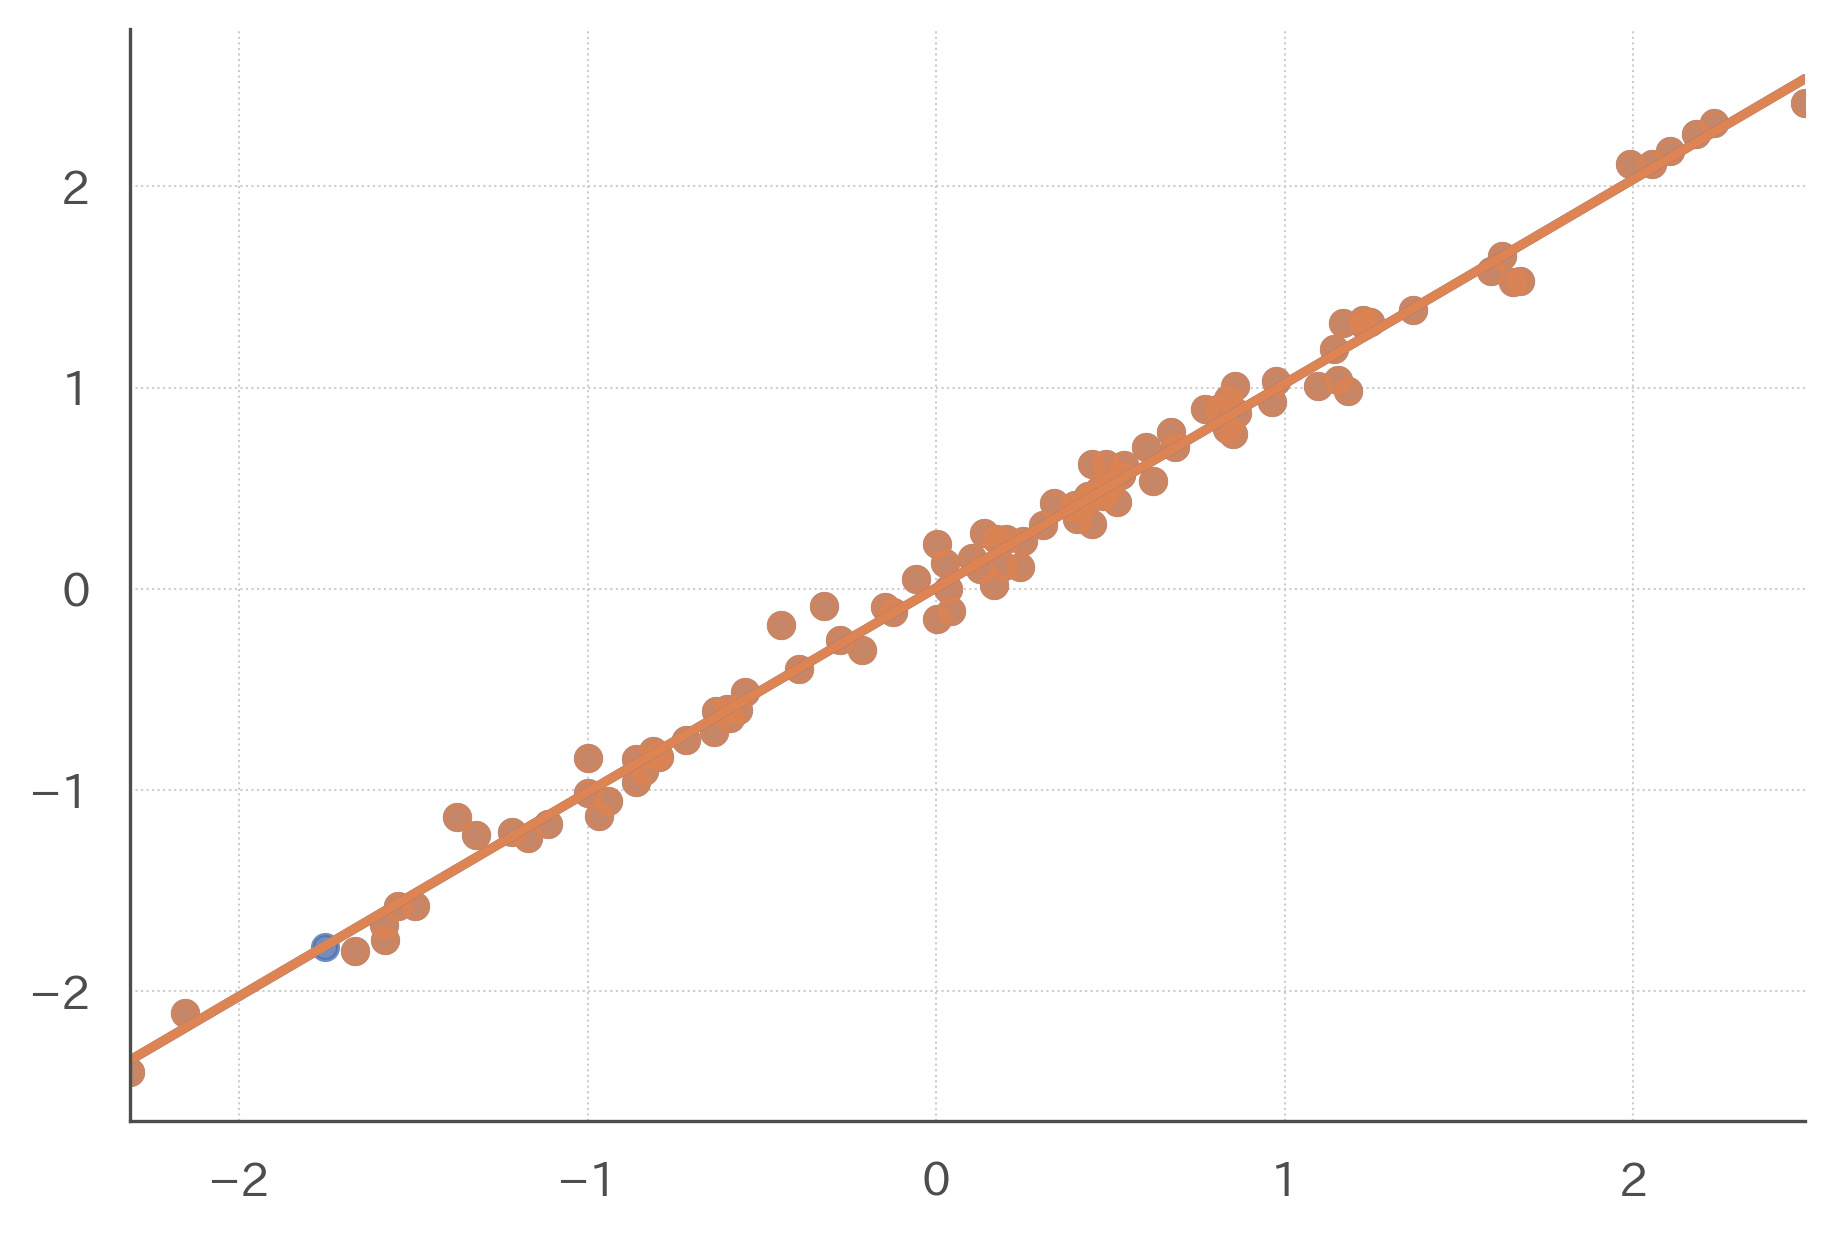

In [152]:
fig, ax = plt.subplots()
sns.regplot(x, y, ci=None, ax=ax)
sns.regplot(np.delete(x, 0), np.delete(y, 0), ci=None, ax=ax)

In [153]:
mse = np.zeros_like(x)
coefs = np.zeros_like(x)
for i in range(x.shape[0]):
    X_to_use = np.delete(X, i, 0)
    y_to_use = np.delete(y, i, 0)
    
    model = LinearRegression().fit(X_to_use, y_to_use)
    y_pred = model.predict(X) 
    mse[i] = mean_squared_error(y, y_pred)
    
    coefs[i] = model.coef_[0]

In [159]:
coefs

array([1.0159093 , 1.01625563, 1.01558123, 1.01608618, 1.01823138,
       1.0162197 , 1.01443717, 1.01574795, 1.01606443, 1.01467249,
       1.01862224, 1.01605956, 1.01539549, 1.01356493, 1.01543244,
       1.01517859, 1.01764268, 1.01541503, 1.01633532, 1.01580778,
       1.01605081, 1.01643604, 1.01609076, 1.01476602, 1.01407594,
       1.01499957, 1.01605389, 1.01615546, 1.01581384, 1.01561179,
       1.01596769, 1.01514423, 1.01606224, 1.01565805, 1.01754039,
       1.01561602, 1.01617714, 1.0153793 , 1.01600701, 1.01982402,
       1.01613989, 1.01604342, 1.0167312 , 1.01515349, 1.01590371,
       1.01574052, 1.01574448, 1.0158424 , 1.01602925, 1.01778769,
       1.01558497, 1.01552319, 1.01836476, 1.01652123, 1.01618039,
       1.01564869, 1.01787439, 1.01601745, 1.0144839 , 1.01604042,
       1.01659262, 1.0158589 , 1.01585034, 1.01589696, 1.0160047 ,
       1.0160404 , 1.01581459, 1.01604726, 1.01600366, 1.01640387,
       1.01612022, 1.01602889, 1.01737064, 1.01636862, 1.01601

In [158]:
theta_hat = LinearRegression().fit(X, y).coef_
(coefs - theta_hat)

array([-1.38906283e-04,  2.07424615e-04, -4.66979518e-04,  3.79718806e-05,
        2.18317047e-03,  1.71490108e-04, -1.61103476e-03, -3.00261062e-04,
        1.62189257e-05, -1.37572032e-03,  2.57403455e-03,  1.13496788e-05,
       -6.52714717e-04, -2.48327576e-03, -6.15772785e-04, -8.69620520e-04,
        1.59447159e-03, -6.33183332e-04,  2.87115359e-04, -2.40429222e-04,
        2.59930573e-06,  3.87829720e-04,  4.25461095e-05, -1.28218710e-03,
       -1.97226944e-03, -1.04863778e-03,  5.68411335e-06,  1.07248323e-04,
       -2.34368638e-04, -4.36423237e-04, -8.05211180e-05, -9.03980401e-04,
        1.40331247e-05, -3.90155650e-04,  1.49218223e-03, -4.32187301e-04,
        1.28931130e-04, -6.68907647e-04, -4.11959949e-05,  3.77581532e-03,
        9.16792770e-05, -4.78863106e-06,  6.82994939e-04, -8.94719444e-04,
       -1.44497499e-04, -3.07693119e-04, -3.03730418e-04, -2.05805458e-04,
       -1.89614742e-05,  1.73947921e-03, -4.63235880e-04, -5.25019179e-04,
        2.31655491e-03,  

In [167]:
def influence(X, y, theta):
    x = X.flatten()
    
    return -(y - x * theta)*x / np.mean(x**2) / X.shape[0]


infs = influence(X, y, theta_hat)
infs

array([-5.89498599e-05,  2.01859842e-04, -5.96566796e-04,  2.35276713e-04,
        2.34340582e-03,  2.42033107e-04, -1.31623879e-03, -2.17748279e-04,
       -4.60518734e-05, -1.10662186e-03,  2.61225709e-03,  6.32585081e-07,
       -7.52011603e-04, -2.09758274e-03, -7.11046496e-04, -9.43467291e-04,
        1.41814885e-03, -7.77511146e-04, -2.25021211e-06, -1.53916985e-04,
       -1.38289873e-05,  4.22309092e-04,  5.44885331e-05, -1.44468698e-03,
       -1.65363645e-03, -8.54902660e-04, -1.70451988e-04, -2.37463490e-05,
       -1.63713677e-04, -5.40043900e-04, -1.25145072e-04, -1.07658934e-03,
        1.06881097e-05, -5.15388250e-04,  1.11343830e-03, -5.07738857e-04,
        1.34461782e-04, -7.45490938e-04,  1.19136744e-05,  3.30390428e-03,
        4.97323327e-05,  3.39813154e-05,  7.61940514e-04, -1.01508461e-03,
       -2.52965602e-04, -2.19379844e-04, -3.77199412e-04,  1.04947543e-06,
       -4.73008149e-05,  1.58323176e-03, -6.73136783e-04, -3.92963406e-04,
        2.34989495e-03,  

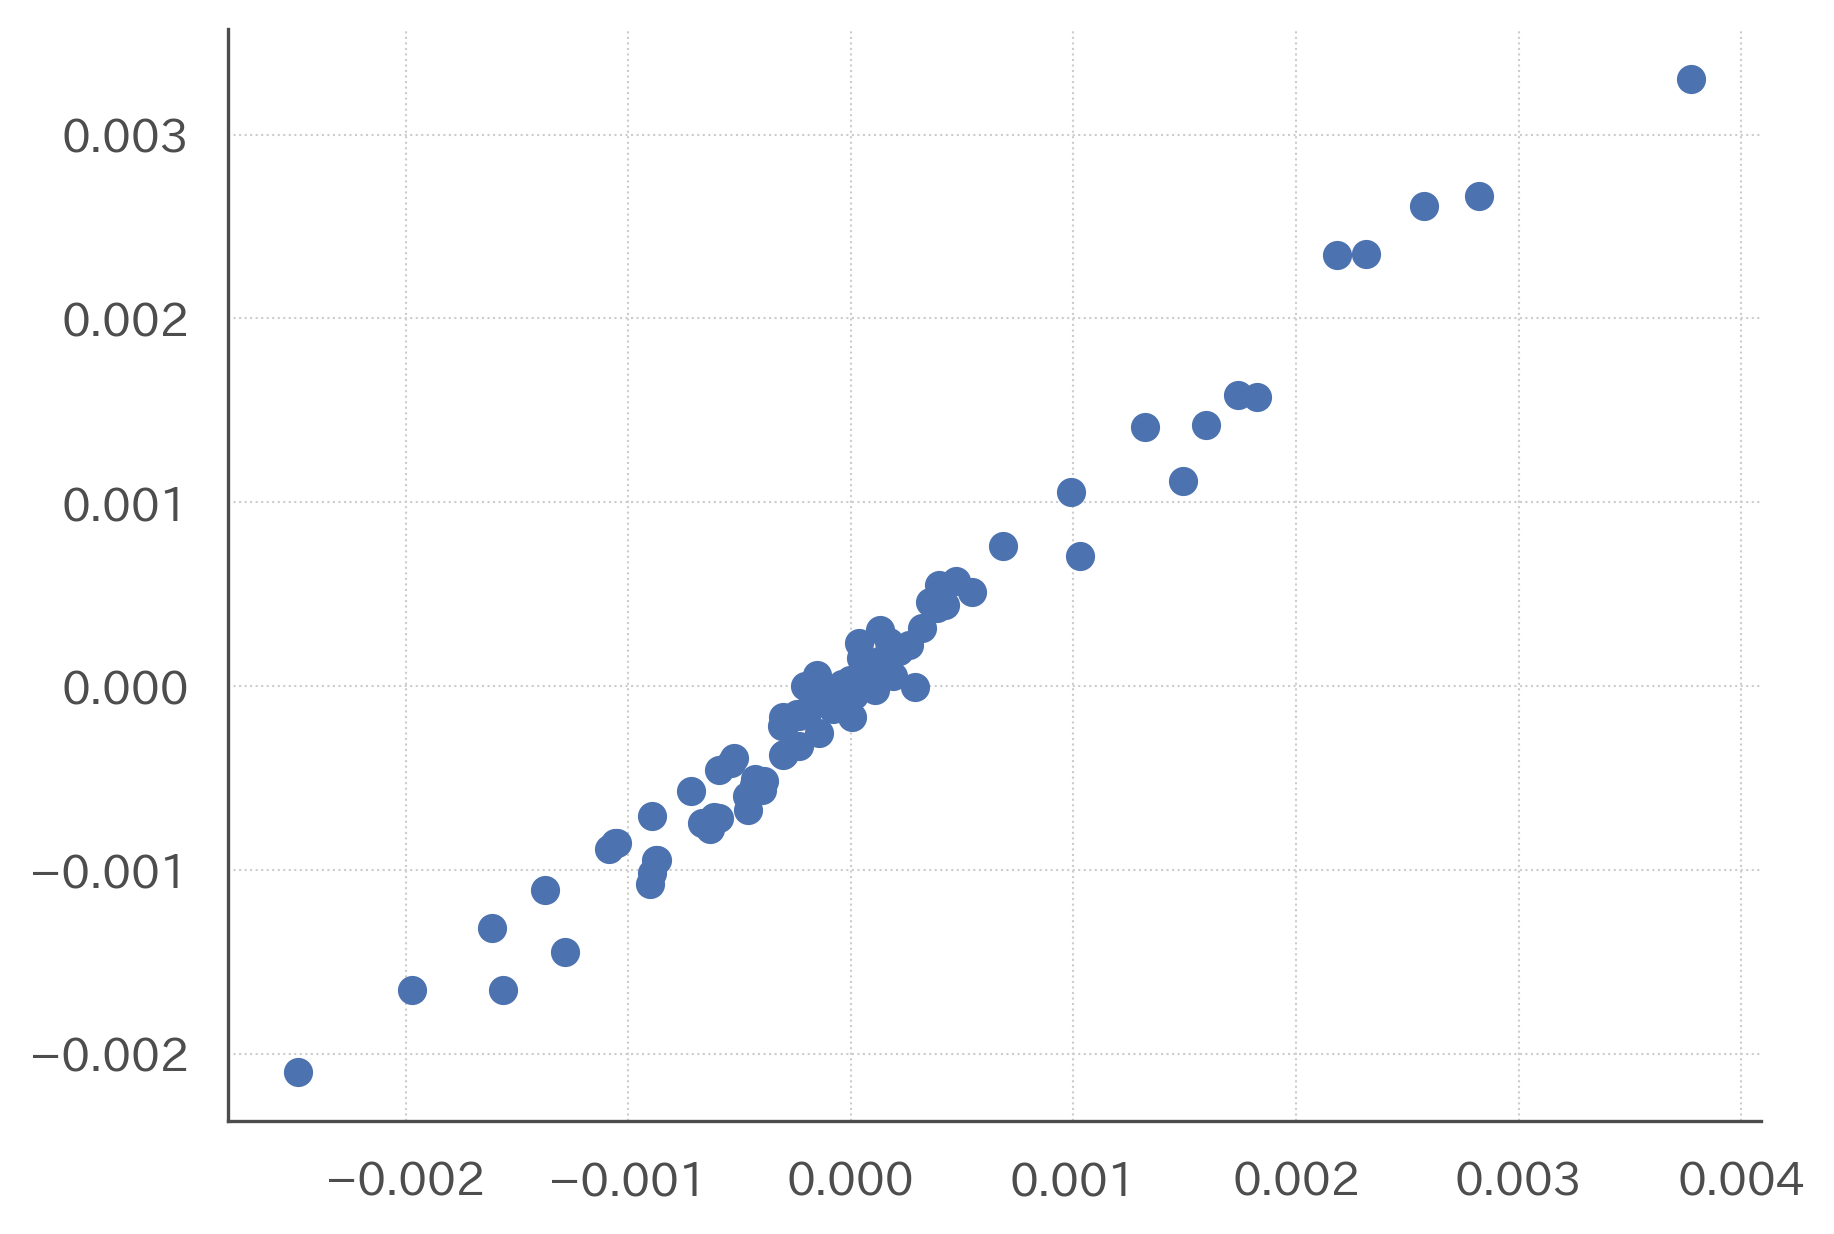

In [169]:
fig, ax = plt.subplots()
xx = np.arange(0, 1, 0.01)
ax.scatter((coefs - theta_hat), infs)
#ax.plot(xx, xx)

In [ ]:
np.gradient()

In [82]:
def P(X):
    return X @ np.linalg.inv(X.T@X) @ X.T

def M(X):
    I = np.eye(X.shape[0])
    return I - P(X)


M(X) @ y

array([-0.86495124,  0.0422609 , -0.01614202,  0.09635508, -0.05346009,
        0.15475609,  0.02025595,  0.05640859,  0.05485382,  0.06954679,
        0.11454313, -0.02871716, -0.05480717,  0.04918461, -0.0895485 ,
       -0.04169775,  0.00482746,  0.1433727 ,  0.03268186,  0.0804703 ,
        0.10674873,  0.05017944,  0.11268392,  0.06165222,  0.07599889,
       -0.01170765, -0.23109074,  0.05598495,  0.16657274,  0.1370882 ])

In [85]:
np.diag(P(X)) * (M(X) @ y)

array([-6.91635383e-02,  3.23311963e-03, -2.34707228e-04,  7.00931848e-03,
       -4.89574037e-04,  3.11241181e-03,  9.16894543e-05,  2.05016770e-03,
        4.65793975e-03,  2.24419236e-03,  1.29933846e-03, -1.06778825e-03,
       -7.33712089e-05,  3.44142208e-03, -2.00806422e-03, -7.45967576e-04,
        1.46808774e-04,  4.95866113e-03,  1.49176812e-05,  3.32222071e-03,
        5.53587879e-04,  2.26622453e-03,  6.75474349e-03,  3.53064722e-03,
        2.05547258e-03, -2.80671693e-04, -4.17964357e-04,  2.98195411e-03,
        1.08715634e-03,  2.99653089e-03])

In [96]:
mse

array([0.1895623 , 0.18059032, 0.18054945, 0.18068548, 0.18058684,
       0.18061229, 0.18054554, 0.18055317, 0.1806377 , 0.18055645,
       0.18058549, 0.18054626, 0.18070128, 0.18058695, 0.18057986,
       0.180557  , 0.18054269, 0.18061121, 0.18054862, 0.18056994,
       0.18058871, 0.1805559 , 0.18065728, 0.18057806, 0.18055693,
       0.1805447 , 0.18162581, 0.18056734, 0.18068509, 0.18059482])

In [97]:
((1 - np.diag(P(X))).reshape(-1, 1) @ (M(X) @ y).reshape(1, -1)).mean(0)

array([-0.83611954,  0.04085221, -0.01560395,  0.09314324, -0.05167809,
        0.14959755,  0.01958076,  0.0545283 ,  0.05302536,  0.06722857,
        0.11072503, -0.02775992, -0.05298027,  0.04754512, -0.08656355,
       -0.04030782,  0.00466655,  0.13859361,  0.03159247,  0.07778796,
        0.10319044,  0.04850679,  0.10892779,  0.05959714,  0.07346559,
       -0.0113174 , -0.22338772,  0.05411879,  0.16102032,  0.13251859])